In [2]:
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from sympy.physics.vector import init_vprinting, vlatex
init_vprinting(use_latex = True, pretty_print = False)
from scipy.integrate import odeint
from pydy.codegen.ode_function_generators import generate_ode_function
from pydy.viz.shapes import Cylinder, Sphere
import pydy.viz
pydy.viz.shapes.__all__
from pydy.viz.visualization_frame import VisualizationFrame
from pydy.viz.scene import Scene
from matplotlib.pyplot import plot, legend, xlabel, ylabel, rcParams
rcParams['figure.figsize'] = (14.0, 6.0)

# Kinematics  

**Reference Frames:** Declare inertial reference frames and frames for each body

In [3]:
inertial_frame = me.ReferenceFrame('I')
lower_leg_frame = me.ReferenceFrame('L')
upper_leg_frame = me.ReferenceFrame('U')
torso_frame = me.ReferenceFrame('T')

**Coordinates:** Declaring coordinates for each of the joint angle.

In [4]:
theta1, theta2, theta3 = me.dynamicsymbols('theta1 theta2 theta3')

**Orient Frames:** Orient each of the reference frames according to the coordinate

In [5]:
lower_leg_frame.orient(inertial_frame,'Axis',(theta1,inertial_frame.z)) 
upper_leg_frame.orient(lower_leg_frame,'Axis',(theta2,lower_leg_frame.z))
torso_frame.orient(upper_leg_frame,'Axis',(theta3,upper_leg_frame.z))

**Joints:** Set the position of each of the joints

In [6]:
#Ankle
ankle = me.Point('A')
#Knee
lower_leg_length = sm.symbols('l_L')
knee = me.Point('K')
knee.set_pos(ankle,lower_leg_length*lower_leg_frame.y)
knee.pos_from(ankle)
#Hip
upper_leg_length = sm.symbols('l_U')
hip = me.Point('H')
hip.set_pos(knee,upper_leg_length*upper_leg_frame.y)
hip.pos_from(ankle)


**Centre of Mass:** Set the position of the CoM of each segment

In [7]:
#Lower leg
lower_leg_com_length = sm.symbols('d_L')
lower_leg_mass_center = me.Point('L_o')
lower_leg_mass_center.set_pos(ankle,lower_leg_com_length*lower_leg_frame.y)
lower_leg_mass_center.pos_from(ankle)

#Upper Leg
upper_leg_com_length = sm.symbols('d_U')
upper_leg_mass_center = me.Point('U_o')
upper_leg_mass_center.set_pos(knee,upper_leg_com_length*upper_leg_frame.y)
upper_leg_mass_center.pos_from(ankle)

#Torso
torso_com_length = sm.symbols('d_T')
torso_mass_center = me.Point('T_o')
torso_mass_center.set_pos(hip,torso_com_length*torso_frame.y)
torso_mass_center.pos_from(ankle)

**Kinematical Differential Equations:** Declare generalized speeds of each coordinate and relate them to the generalized coordinates to form the *Kinematical Differential Equations*

In [8]:
omega1, omega2, omega3 = me.dynamicsymbols('omega1 omega2 omega3')

kinematical_differential_equations = [omega1 - theta1.diff(),
                                      omega2 - theta2.diff(),
                                      omega3 - theta3.diff()]

**Angular Velcoities:** Now we can use the defined generalized speeds to specify the angular velocity of each of the coordinate system


In [9]:
#Lower Leg
lower_leg_frame.set_ang_vel(inertial_frame,omega1*inertial_frame.z)
lower_leg_frame.ang_vel_in(inertial_frame)

#Upper Leg
upper_leg_frame.set_ang_vel(lower_leg_frame,omega2*lower_leg_frame.z)
upper_leg_frame.ang_vel_in(inertial_frame)

#Torso
torso_frame.set_ang_vel(upper_leg_frame,omega3*upper_leg_frame.z)
torso_frame.ang_vel_in(inertial_frame)

**Linear Velocities:** Define the linear velocity of each of the CoM starting from the ankle that has a linear velocity of zero

In [10]:
ankle.set_vel(inertial_frame,0)

#Lower Leg
lower_leg_mass_center.v2pt_theory(ankle,inertial_frame,lower_leg_frame)
lower_leg_mass_center.vel(inertial_frame)

#Knee
knee.v2pt_theory(ankle,inertial_frame,lower_leg_frame)
knee.vel(inertial_frame)

#Upper Leg
upper_leg_mass_center.v2pt_theory(knee,inertial_frame,upper_leg_frame)
upper_leg_mass_center.vel(inertial_frame)

#Hip
hip.v2pt_theory(knee,inertial_frame,upper_leg_frame)
hip.vel(inertial_frame)

#Torso
torso_mass_center.v2pt_theory(hip,inertial_frame,torso_frame)
torso_mass_center.vel(inertial_frame)


# Inertia

**Mass:** Define the mass of each segment

In [11]:
lower_leg_mass, upper_leg_mass, torso_mass = sm.symbols('m_L, m_U,m_L')

**Moment of Inertia:** Define the moment of inertia of each segment

In [12]:
lower_leg_inertia, upper_leg_inertia, torso_inertia = sm.symbols('I_Lz I_Uz I_Tz')

#Lower Leg
lower_leg_inertia_dyadic = me.inertia(lower_leg_frame,0,0,lower_leg_inertia)
lower_leg_inertia_dyadic.to_matrix(lower_leg_frame)
lower_leg_central_inertia = (lower_leg_inertia_dyadic,lower_leg_mass_center)

#Upper Leg
upper_leg_inertia_dyadic = me.inertia(upper_leg_frame,0,0,upper_leg_inertia)
upper_leg_inertia_dyadic.to_matrix(upper_leg_frame)
upper_leg_central_inertia = (upper_leg_inertia_dyadic,upper_leg_mass_center)

#Torso
torso_inertia_dyadic = me.inertia(torso_frame,0,0,torso_inertia)
torso_inertia_dyadic.to_matrix(torso_frame)
torso_central_inertia = (torso_inertia_dyadic,torso_mass_center)


**Rigid Bodies:** Define rigid bodies for each of the segments  

In [13]:
lower_leg = me.RigidBody('Lower Leg',lower_leg_mass_center,lower_leg_frame,
                         lower_leg_mass,lower_leg_central_inertia )

upper_leg = me.RigidBody('Upper Leg',upper_leg_mass_center,upper_leg_frame,
                         upper_leg_mass,upper_leg_central_inertia)

torso = me.RigidBody('Torso', torso_mass_center, torso_frame,
                     torso_mass, torso_central_inertia)

 

# Kinetics

**Gravity:** Define the gravitational force for each segment

In [14]:
g = sm.symbols('g')

#Lower Leg
lower_leg_grav_force_vector = -lower_leg_mass*g*inertial_frame.y
lower_leg_grav_force = (lower_leg_mass_center,lower_leg_grav_force_vector)
#Upper Leg
upper_leg_grav_force_vector = -upper_leg_mass*g*inertial_frame.y
upper_leg_grav_force = (upper_leg_mass_center,upper_leg_grav_force_vector)
#Torso
torso_grav_force_vector = -torso_mass*g*inertial_frame.y
torso_grav_force = (torso_mass_center,torso_grav_force_vector)


**Joint Torque:** Define the torque acting at the hip, knee, and ankle

In [15]:
ankle_torque, knee_torque, hip_torque = me.dynamicsymbols('T_a T_k T_h')

lower_leg_torque_vector = ankle_torque*inertial_frame.z - knee_torque*inertial_frame.z
lower_leg_torque = (lower_leg_frame,lower_leg_torque_vector)

upper_leg_torque_vector = knee_torque*inertial_frame.z - hip_torque*inertial_frame.z
upper_leg_torque = (upper_leg_frame,upper_leg_torque_vector)

torso_torque_vector = hip_torque*inertial_frame.z
torso_torque = (torso_frame,torso_torque_vector)

# Equations of Motion

**Kane's Method:** Use *Kane's Method* to determine the equations of motion

In [16]:
coordinates = [theta1, theta2, theta3]
speeds = [omega1, omega2, omega3]

kane = me.KanesMethod(inertial_frame,coordinates,speeds,kinematical_differential_equations)

loads = [lower_leg_grav_force,
         upper_leg_grav_force,
         torso_grav_force,
         lower_leg_torque,
         upper_leg_torque,
         torso_torque]

bodies = [lower_leg,upper_leg,torso]

fr, frstar = kane.kanes_equations(bodies,loads)
sm.trigsimp(fr + frstar)

#Pull out the mass and forcing matrix for later use
mass_matrix = sm.trigsimp(kane.mass_matrix_full)
forcing_vector = sm.trigsimp(kane.forcing_full)



# Simulate

**Variables:** Declare variables for the integration

In [17]:
constants = [lower_leg_length,
             lower_leg_com_length,
             lower_leg_mass,
             lower_leg_inertia,
             upper_leg_length,
             upper_leg_com_length,
             upper_leg_mass,
             upper_leg_inertia,
             torso_com_length,
             torso_mass,
             torso_inertia,
             g]

coordinates = [theta1, theta2, theta3]
speeds = [omega1, omega2, omega3]

specified = [ankle_torque, knee_torque, hip_torque]

**Generate Numerical ODE Function:** Use PyDy to generate the ODEs for odeint to integrate

In [18]:
right_hand_side = generate_ode_function(forcing_vector,
                                        coordinates,speeds,
                                        constants,
                                        mass_matrix = mass_matrix,
                                        specifieds = specified)

type(right_hand_side)
help(right_hand_side)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.

    x' = f(x, t, r, p)

    Parameters
    x : ndarray, shape(6,)
        The state vector is ordered as such:
            - theta1(t)
            - theta2(t)
            - theta3(t)
            - omega1(t)
            - omega2(t)
            - omega3(t)
    t : float
        The current time.
    r : dictionary; ndarray, shape(3,); function

        There are three options for this argument. (1) is more flexible but
        (2) and (3) are much more efficient.

        (1) A dictionary that maps the specified functions of time to floats,
        ndarrays, or functions that produce ndarrays. The keys can be a single
        specified symbolic function of time or a tuple of symbols. The total
        number of symbols must be equal to 3. If the value is a
        function 

**Function Inputs:** Set the initial conditions, paramter values, and time array

In [19]:
#Initial Conditions
x0 = np.zeros(6)

#Parameter Values
numerical_constants = np.array([0.611,  # lower_leg_length [m]
                             0.387,  # lower_leg_com_length [m]
                             6.769,  # lower_leg_mass [kg]
                             0.101,  # lower_leg_inertia [kg*m^2]
                             0.424,  # upper_leg_length [m]
                             0.193,  # upper_leg_com_length
                             17.01,  # upper_leg_mass [kg]
                             0.282,  # upper_leg_inertia [kg*m^2]
                             0.305,  # torso_com_length [m]
                             32.44,  # torso_mass [kg]
                             1.485,  # torso_inertia [kg*m^2]
                             9.81],  # acceleration due to gravity [m/s^2]
                            ) 

numerical_specified = np.zeros(3)

args = {'constants': numerical_constants,
        'specified': numerical_specified}

frames_per_sec = 60.0
final_time = 5.0

t = np.linspace(0.0, final_time, int(final_time * frames_per_sec))


**Integrate the ODE:** Use odeint to integrate the RHS of the equations of motion

In [20]:
y = odeint(right_hand_side,x0,t,args=(numerical_specified,numerical_constants))

**Plot:** Plot the coordinates and speeds

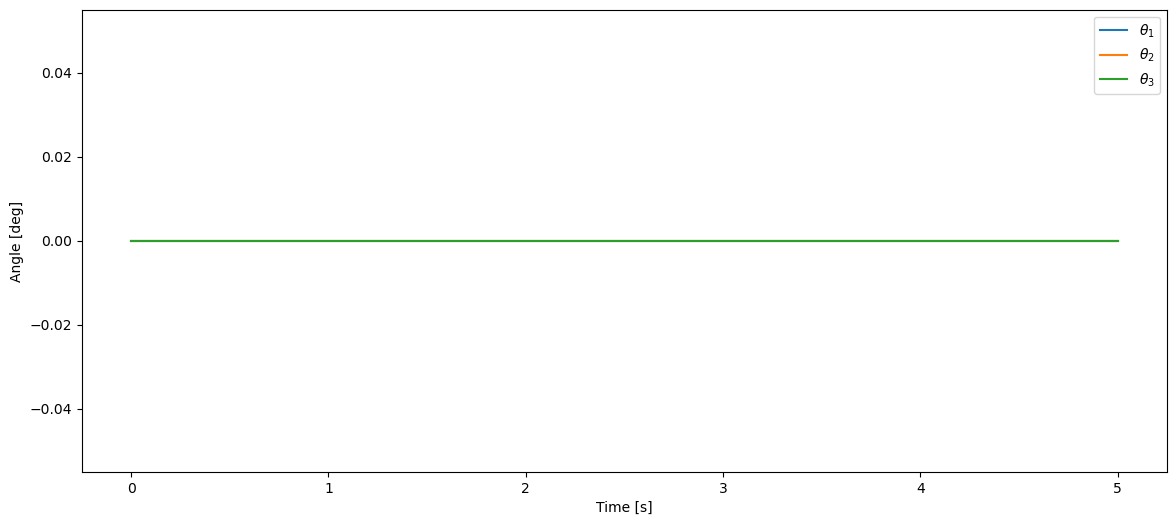

In [21]:
plot(t,np.rad2deg(y[:,:3]))
xlabel('Time [s]')
ylabel('Angle [deg]')
legend(["${}$".format(vlatex(c)) for c in coordinates])



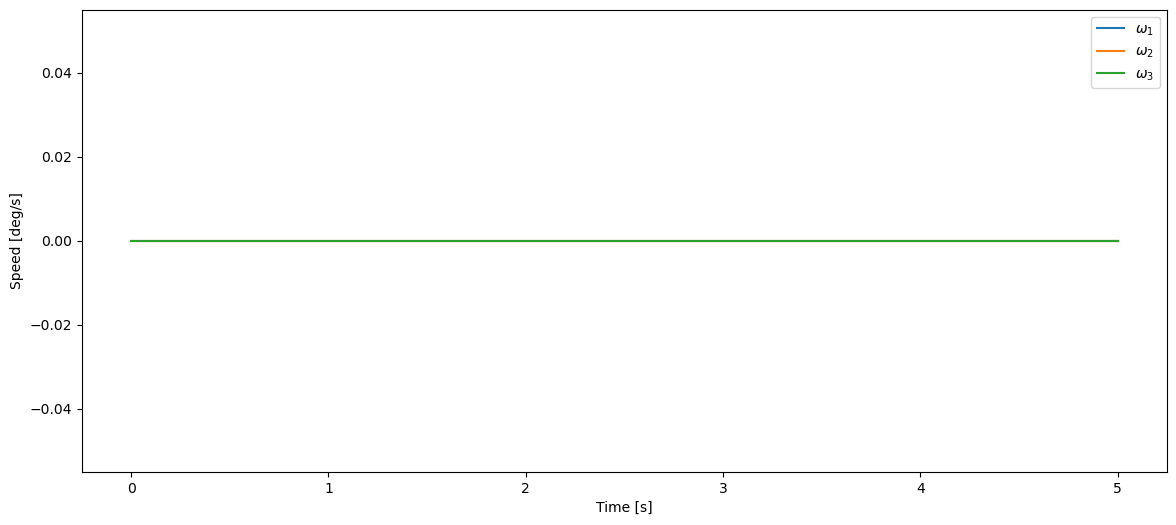

In [22]:
plot(t,np.rad2deg(y[:,3:]))
xlabel('Time [s]')
ylabel('Speed [deg/s]')
legend(["${}$".format(vlatex(s)) for s in speeds])

# Visualization

In [23]:
ankle_shape = Sphere(color = 'black', radius = 0.1)
knee_shape = Sphere(color = 'black', radius = 0.1)
hip_shape = Sphere(color = 'black', radius = 0.1)
head_shape = Sphere(color = 'black', radius = 0.125)

ankle_viz_frame = VisualizationFrame(inertial_frame,ankle,ankle_shape)
knee_viz_frame = VisualizationFrame(inertial_frame,knee,knee_shape)
hip_viz_frame = VisualizationFrame(inertial_frame,hip,hip_shape)

head = me.Point('N')
head.set_pos(hip,2*torso_com_length*torso_frame.y)
head_viz_frame = VisualizationFrame(inertial_frame,head,head_shape)

lower_leg_center = me.Point('l_c')
upper_leg_center = me.Point('u_c')
torso_center = me.Point('t_c')

lower_leg_center.set_pos(ankle,(lower_leg_length/2)*lower_leg_frame.y)
upper_leg_center.set_pos(knee,(upper_leg_length/2)*upper_leg_frame.y)
torso_center.set_pos(hip,torso_com_length*torso_frame.y)

constants_dict = dict(zip(constants,numerical_constants))

lower_leg_shape = Cylinder(radius=0.08, length=constants_dict[lower_leg_length], color='blue')
lower_leg_viz_frame = VisualizationFrame('Lower Leg',lower_leg_frame,lower_leg_center,lower_leg_shape)

upper_leg_shape = Cylinder(radius=0.08, length=constants_dict[upper_leg_length], color='green')
upper_leg_viz_frame = VisualizationFrame('Upper Leg',upper_leg_frame,upper_leg_center,upper_leg_shape)

torso_shape = Cylinder(radius=0.08, length=2*constants_dict[torso_com_length], color='red')
torso_viz_frame = VisualizationFrame('Torso',torso_frame,torso_center,torso_shape)

scene = Scene(inertial_frame,ankle)

scene.visualization_frames = [ankle_viz_frame,
                              knee_viz_frame,
                              hip_viz_frame,
                              head_viz_frame,
                              lower_leg_viz_frame,
                              upper_leg_viz_frame,
                              torso_viz_frame]

scene.states_symbols = coordinates + speeds
scene.constants = constants_dict
scene.states_trajectories = y



In [24]:
scene.display()

c:\Users\anbes\Documents\ReactiveBalanceSim\Learning\Feet_In_Place\pydy-resources
Serving HTTP on 127.0.0.1 port 8005 ...
To view visualization, open:

http://localhost:8005/index.html?load=2025-03-11_10-44-02_scene_desc.json
Press Ctrl+C to stop server...


127.0.0.1 - - [11/Mar/2025 10:44:05] "GET /index.html?load=2025-03-11_10-44-02_scene_desc.json HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2025 10:44:05] "GET /css/bootstrap.min.css HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2025 10:44:05] "GET /css/slider.css HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2025 10:44:05] "GET /css/main.css HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2025 10:44:05] "GET /css/codemirror/codemirror.css HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2025 10:44:05] "GET /css/codemirror/blackboard.css HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2025 10:44:05] "GET /js/external/jquery/jquery.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2025 10:44:05] "GET /js/external/jquery/jquery-ui.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2025 10:44:05] "GET /js/external/bootstrap/bootstrap.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2025 10:44:06] "GET /js/external/codemirror/codemirror.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Mar/2025 10:44:06] "GET /js/external/codemirror/javascript-mode.js HTTP/1.1" 200 -
127.0.